# Explain CNN

# Contents

## TOC:
* [Imports](#imports)
* [Model Loader](#modelloader)
   * [Loading Model](#loadingmodel)
   * [Transform Function](#transformfunction)
   * [Class Dict](#classdict)
   * [Get Params](#getparams)
   * [Shortly](#shortly)
* [Explainer](#explainer)
   * [Some Notes on Algorithmic Design](#notes)
   * [Some Predictions](#somepredictions)

   

### Imports  <a class="anchor" id="imports"></a>


In [185]:
from __future__ import print_function, division
import numpy as np
# explain import
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
# visualize import
import matplotlib.pyplot as plt
from PIL import Image
# utils import
from tqdm import tqdm
import time
import os
import copy
import importlib
import pickle
# torch import
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

plt.ion()   # interactive mode

## Model Loader  <a class="anchor" id="modelloader"></a>
Creating a generic model loader that absorbs every kind of model is a trivial thing, that requires covering lots of cases, lots of possibilities. For this toy problem, PyTorch is targeted. 

Explainability is a tool, but model structure shouldn't change for explainability. We should obtain the model as it is, and explain with minimal changes on PyTorch structure of the model. To be clear, what is desired:

1. Model should be obtained as it's trained/deployed. However, this is trivial because of PyTorch's Sequential vs. Functional API.
2. Model weights should be correctly uploaded to corresponding layers.
3. Data should be transformed as it's test data transformed, assuming that test data is represented as production code.

Because of that, model_loader requests 4 files: 


    * class_dict.pkl : Dictionary that contains index of prediction and corresponding class. If model predictions are in form of 0,1,2; class_dict.pkl should be {0: "Class A", 1:"Class B", 2:"Class C"}
    * transform_preprocess.py : py file that contains "transform_image" function.  This function should take image path, and transform image, then returns transformed image. An example form is :
        
        def transform_image(image_path):
    data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return data_transforms(Image.open(image_path))
    
    * model.pyt : model file that has .pyt file extension, saved by torch.save(model.state_dict(),"model.pyt") 
    
    * model_script.py : model script that includes class,which strictly having name "Model", in such a format: 
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torchvision
    from torchvision import datasets, models, transforms
    class Model(nn.Module): ### It should strictly be "Model"
    def __init__(self):
        super(Model, self).__init__() ### It should strictly be "Model"
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x




First I'll put the ModelLoader class, then explain its function and properties.


In [34]:
class ModelLoader:
    """
    Loads the model from model folder given model_script.py, transform_image.py, model weight that ends with ".pyt" extension and class_dict.pkl file that indexes model prediction with class names.
    Use Case:
    model_loader = ModelLoader("models/model_test/")
    model,class_dict,transform_func = model_loader.get_params()

    """
    def __init__(self,model_folder):
        self.model_folder = model_folder
        self.files = os.listdir(model_folder)    
        
    def create_model(self):
        """Creates model from model_script.py and returns the model.
        
        Returns:
            model_package_module.Model() : Model Class
        
        """
        
        model_package_file = (self.model_folder+ "model_script").replace("/",".")
        model_package_module = importlib.import_module(model_package_file)
        return model_package_module.Model()
    
    def load_model(self):
        """Load PyTorch model.
        
        Returns:
            model : PyTorch model with weights loaded
        
        """
        
        model = self.create_model()
        model_weighst_file_pyt = [i for i in self.files if "pyt" in i][0]
        model_weights_file_full_path = self.model_folder+model_weighst_file_pyt
        loaded_state = torch.load(model_weights_file_full_path,map_location=torch.device('cpu'))
        model.load_state_dict(loaded_state) ### In order to convert gpu models to cpu.
        model.eval() ## Needed in order to convert from training mode to eval mode.
        return model
    
    def load_class_dict(self):
        """Loads class dict from pickle.
        Returns:
            class_dict : dict Class dictionary {0:"Class A",1:"Class B"}
        """

        class_file = [i for i in self.files if "class_dict." in i][0]        
        with open(self.model_folder+class_file, 'rb') as pickle_file:
            class_dict = pickle.load(pickle_file)
        return class_dict
    
    def import_transform(self):
        """Imports transform function. Function should be located inside transform_preprocess.py that has a name of "transform_image".
        
        """
    
        transform_package_file = (self.model_folder+ "transform_preprocess").replace("/",".")
        transform_preprocess_module = importlib.import_module(transform_package_file)
        return transform_preprocess_module.transform_image
    
    def get_params(self):
        """Get parameters of model that's desired to be loaded.
        
        Returns:
            model : PyTorch model that weights are loaded.
            class_dict : Class dictionary
            transform_function : Raw image transform function.
        """
        
        model = self.load_model()
        class_dict = self.load_class_dict()
        transform_function = self.import_transform()
        return model,class_dict, transform_function


#### Loading Model   <a class="anchor" id="loadingmodel"></a>

In order to fulfill these three constrainst, it's required to obtain functions/model scripts etc. which are more than having only single weight file. Having only the model weights along with transformation function could be OK, however, the team who created the model may name the layers for some purpose. Or, not only having the model weights but also the detailed model structure will be more helpful way of ensuring the model that we inspect is a correct one that's used in production. 

Here's the way to load an example model on PyTorch, using ModelLoader class.

In [35]:
example_model_path = "models/model_example/"
model_loader = ModelLoader(example_model_path)
model,class_dict,transform_func = model_loader.get_params()


We first define the model as:

In [43]:
"""
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1_1 = nn.Conv2d(1, 20, 5)
        self.conv2_1 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        return F.softmax(F.relu(self.conv2_1(x)))
"""


'\nclass Model(nn.Module):\n    def __init__(self):\n        super(Model, self).__init__()\n        self.conv1_1 = nn.Conv2d(1, 20, 5)\n        self.conv2_1 = nn.Conv2d(20, 20, 5)\n\n    def forward(self, x):\n        x = F.relu(self.conv1_1(x))\n        return F.softmax(F.relu(self.conv2_1(x)))\n'

Model is loaded as it's way that it's created, check for variable names conv1_1,conv2_1: 

In [44]:
model_loader.create_model()

Model(
  (conv1_1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_1): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1))
)

Thus, using model.state_dict, model architecture and layer names are preserved. That's what we should be require from model creators in order to ensure the model that we load is a correct one used in production. 


### Transform Function <a class="anchor" id="transformfunction"></a>
Transform function is necessary, to ensure that model transforms in a way that it's transformed on production.
It requires image_path as an input, torch tensor as an output, and it would be tensorflow tensor in tensorflow.

Note : This function doesn't transform image to image, does transform single image to torch tensor array. It should be ready to put to the model for inference.

Transform image function for this example : 

"""

from torchvision import transforms
from PIL import Image
import torch

def transform_image(image_path):

    data_transforms = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])   ])

    torch_img = data_transforms(Image.open(image_path))

    return torch.reshape(torch_img,(-1,3,224,224))

"""



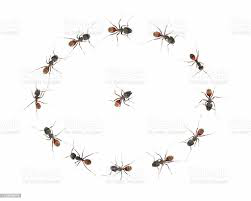

In [81]:
transform_func = model_loader.import_transform()
example_img="/Users/mehmetburaksayici/Desktop/Projects/expmed/models/model_example/exp_images/ant.jpg"
Image.open(example_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Type is : <class 'torch.Tensor'>
View Transformed image is


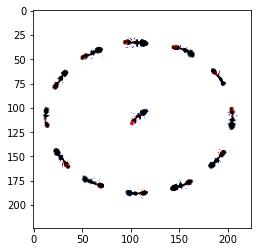

In [82]:
print("Type is :", type(transform_func(example_img)))
print("View Transformed image is")
plt.imshow(np.moveaxis(np.array(transform_func(example_img)[0]), 0,2))

### class dict <a class="anchor" id="classdict"></a>
In the toy problem, we considered classification task. Explanations are not limited to classification, but also for regression/segmentation problems. class_dict is shortly {0:"Class A",1:"Class B"}, since model predicts one of the classes as an integer number from 0 to no_of_classes.

In [83]:
print(class_dict)

{0: 'ant', 1: 'bee'}


### get_params <a class="anchor" id="getparams"></a>

get_params is a wrapper(not exactly, but can be think of) of other functions to obtain all files, loads model and weights.


In [84]:
example_model_path = "models/model_example/"
model_loader = ModelLoader(example_model_path)
model,class_dict,transform_func = model_loader.get_params()


### Shortly <a class="anchor" id="Shortly"></a> 
Class is designed to be simple. A lot of details on models/transform functions are demanded because of ensuring the model. 

## Explainer <a class="anchor" id="explainer"></a>

Explainer Class, is mainly responsible for returning explanation masks for given model and image. Mainly, PyTorch-Grad-Cam library is used as explanation method, but there are other methods such as occlusion maps, or DeepSHAP(that masks some parts of the  image(hides some information) and calculates the effect of masked information). Since this is prototype, I didn't use/implement original techniques, but I have to, for medical purposes.

Explainer class is designed to contain single model itself. Once it's initialized with single model, model related parameters are kept inside self. A very complex design between Explainer and ModelLoader could be inheritance of larger class, etc, where I would prefer to learn/inspect/inspired by scikit-learn code architecture that seems very logical/clean.


In [306]:
from PIL import Image



class Explainer:
    def __init__(self, model,class_dict):
        """Model is the PyTorch model,class_dict is the dictionary of class with keys are index and values are class names."""
        self.model = model
        self.class_dict = class_dict

        
    def set_dataloader(self,dataloader):
        """Set dataloader function that will remain unchanged and applied to all given images. Dataloader should take 
        image path and return transformed torch array which is manipulated with respect to same manner on testing.
        
        Args:
            dataloader: dataloader function
        """
        
        self.dataloader = dataloader
    
    def set_image_path(self,image_path):
        """Set the image path that will be explained
        Args:
            image_path: Image path in string format.
        """
        
        self.image_path = image_path
        
    def set_target_layers(self,target_layer):
        """Set the target layer extracted from the defined model.
        Args:
            target_layer: PyTorch layer
        """
        self.target_layers = target_layer
        
    def predict(self):
        """Predicts the transformed image to return predicted class of explained image.
        
        Returns:
            predicted_class : Name of the predicted class obtained by class_dict
        """
            
        prediction = self.model(self.transformed_image)
        predicted_class = self.class_dict[int(torch.argmax(prediction))]
        return predicted_class

    def get_children(self,model):
        """Obtains flattened the layers of sequential models of PyTorch. It's needed for architectures such as ResNet, that blocks contains more than one layers. This functions separates blocks. References: https://stackoverflow.com/a/65112132/6806531
        
        Args:
            model: PyTorch model
        
        Returns:
            flatt_children : List of separate layers
        """

        children = list(model.children())
        flatt_children = []
        if children == []:
            # if model has no children; model is last child! :O
            return model
        else:
           # look for children from children... to the last child!
           for child in children:
                try:
                    flatt_children.extend(self.get_children(child))
                except TypeError:
                    flatt_children.append(self.get_children(child))
        return flatt_children

    def get_conv_layers(self):
        """Filters convolutional layers on list of layers of PyTorch model. List of convolutional layers needed to choose which convolutional layer to explain, since Grad-Cam method works on convolutional layers.
        
        Returns:
            conv_layers : List of convolutional layers.
        """
        
        self.all_layers = self.get_children(self.model)
        conv_layers = [i for i in self.all_layers if  type(i) == torch.nn.modules.conv.Conv2d ]
        return conv_layers
        
    def transform_image(self,return_image=False):
        """Transforms image to prepare for explainer(PyTorch) models,keeps raw image at self.raw_image, transformed image at self.transformed_image, number of channels(to detect if image is grayscale/RGB) at self.channel.
        """

        self.raw_image = Image.open(self.image_path)
        transformed_img = self.dataloader(self.image_path)   
        self.transformed_image = transformed_img 
        self.channels = self.transformed_image.size(1)
        if return_image: 
            transformed_img
            
    def ablationcam_explainer(self,target_category):
        """AblationCam explainer. Explains why PyTorch model explains target_category by creating heatmap.
        
        Args:
            target_category: binary value that represents class.
        
        Returns:
            grayscale_cam : np.array Explanation mask created by AblationCam.
        """
        
        cam = AblationCAM(model=self.model, target_layer=self.target_layers)
        grayscale_cam = cam(input_tensor=self.transformed_image, target_category=target_category)
        grayscale_cam = grayscale_cam[0, :]
        return grayscale_cam
    
    def eigencam_explainer(self,target_category):
        """EigenCam explainer. Explains why PyTorch model explains target_category by creating heatmap.
        
        Args:
            target_category: binary value that represents class.
        
        Returns:
            grayscale_cam : np.array Explanation mask created by AblationCam.
        """

        cam = EigenCAM(model=self.model, target_layer=self.target_layers)
        grayscale_cam = cam(input_tensor=self.transformed_image, target_category=target_category)
        grayscale_cam = grayscale_cam[0, :]
        return grayscale_cam
    
    def scorecam_explainer(self,target_category):
        """ScoreCam explainer. Explains why PyTorch model explains target_category by creating heatmap.
        
        Args:
            target_category: binary value that represents class.
        
        Returns:
            grayscale_cam : np.array Explanation mask created by AblationCam.
        """
        
        cam = ScoreCAM(model=self.model, target_layer=self.target_layers)
        grayscale_cam = cam(input_tensor=self.transformed_image, target_category=target_category)
        grayscale_cam = grayscale_cam[0, :]
        return grayscale_cam

    def gradcam_explainer(self,target_category):
        """GradCam explainer. Explains why PyTorch model explains target_category by creating heatmap.
        
        Args:
            target_category: binary value that represents class.
        
        Returns:
            grayscale_cam : np.array Explanation mask created by AblationCam.
        """
        
        cam = GradCAM(model=self.model, target_layer=self.target_layers)
        grayscale_cam = cam(input_tensor=self.transformed_image, target_category=target_category)
        grayscale_cam = grayscale_cam[0, :]
        return grayscale_cam

    def gradcamplusplus_explainer(self,target_category):
        """GradCam++ explainer. Explains why PyTorch model explains target_category by creating heatmap.
        
        Args:
            target_category: binary value that represents class.
        
        Returns:
            grayscale_cam : np.array Explanation mask created by AblationCam.
        """
      
        cam = GradCAMPlusPlus(model=self.model, target_layer=self.target_layers)
        grayscale_cam = cam(input_tensor=self.transformed_image, target_category=target_category)
        grayscale_cam = grayscale_cam[0, :]
        return grayscale_cam
    
    def xgradcam_explainer(self,target_category):
        """XGradCam explainer. Explains why PyTorch model explains target_category by creating heatmap.
        
        Args:
            target_category: binary value that represents class.
        
        Returns:
            grayscale_cam : np.array Explanation mask created by AblationCam.
        """

        cam = XGradCAM(model=self.model, target_layer=self.target_layers)
        grayscale_cam = cam(input_tensor=self.transformed_image, target_category=target_category)
        grayscale_cam = grayscale_cam[0, :]
        return grayscale_cam

    def visualize_with_mask(self,grayscale_cam):
        """Combines raw image with mask. It's channel aware, when number of channel is 1, explained image is assumed to be grayscale, when number of channel is 3, it's assumed to be RGB.
        
        Args:
            grayscale_cam: Explanation mask that covers raw image.
        
        Returns:
            visualization : np.array Explained image on NumPy array.
        """

        final_img = np.array(self.raw_image.resize((grayscale_cam.shape[0],grayscale_cam.shape[1])))/255

        if len(np.array(self.raw_image).shape) ==2 or np.array(self.raw_image).shape[0] == 1 or np.array(self.raw_image).shape[-1] == 1 : 
            final_img = np.array([final_img,final_img,final_img])
            final_img = np.moveaxis(final_img,0,2)
        visualization = show_cam_on_image(final_img, grayscale_cam)
        return visualization




Structure of the explainer can be summarized as:

class Explainer:

    initialize model,class dict.                1*
    
    set image path                              2* 
    
    set transformation function                 3*
    
    get possible target layers
    
    set target layer                            4*
    
    explain by chosen method
    
    visualize
    
    
In terms of functions, we can say:

explain_model = Explainer(model,class_dict)                            1*

explain_model.set_dataloader(transform_func)

explain_model.set_image_path(img_path)                                 2* 

explain_model.transform_image()                                        3*

explain_model.set_target_layers(explain_model.get_conv_layers()[idx])  4*

cam_mask = explain_model.xgradcam_explainer(target_category = 1)

vis = explain_model.visualize_with_mask(cam_mask)

plt.imshow(vis)



### Some Notes on Algorithmic Design <a class="anchor" id="notes"></a>

### 1*

Model and class_dict are initialized by 


-> explain_model = Explainer(model,class_dict)

You may wonder why transform image function is not there. Input image transformation function may be desired to be tested prior to explanation. Instead of initializing transformation function, one can assign transformation function via 


-> explain_model.set_image_path(img_path)

-> explain_model.set_dataloader(transform_func)

-> transformed image = explain_model.transform_image(return_image = True)

then check if transformation is in desired manner. If one doesn't like, one can change by calling set_dataloader function again, either by calling script or creating new transformation function on the same .py/.ipynb file. I think giving the flexibility on choosing/creating transform_image function will be good.



### *2 

Instead of setting an image with 

-> explain_model.set_image_path(img_path) 

I may not also initialize image and expect the img_path that every time I would like to visualize an explanation with different method. But, keeping image inside self.transformed_image will give an easiness to directly call explanations masks from different method. So instead of:

-> cam_mask_xgradcam = explain_model.xgradcam_explainer(img_path, target_category = 0)

-> cam_mask_ablationcam  = explain_model.ablationcam_explainer(img_path, target_category = 0)

having this:

-> explain_model.set_image_path(img_path) 

-> cam_mask_xgradcam = explain_model.xgradcam_explainer(target_category = 0)

-> cam_mask_ablationcam  = explain_model.ablationcam_explainer(target_category = 0)

seemed more efficient because we don't re-read/load image every time, and ensure that we explain same image every time.


### 3* 

A simple thing, but, medical imaging techniques have lots of variants, brain MRIs have lots of layers of 2D grayscale images, or there may be WSI images with RGB, or some images may have 2D image but in different colorscale such as HSL/CMYK. Channel is obtained at here, from the path image with PIL library, and saved to 

-> self.channels

Then, visualization function is modified whether the image is grayscale or RGB. In this toy problem, I handled grayscale and RGB, but in production there will definitely be need for other types of data/colorscales.

I'll continue to explain 4* after defining and calling class.

In [308]:
## Get some example image to explain.
example_image_list  = os.listdir("models/model_test/exp_images") 
example_image_list =["models/model_test/exp_images/"+i for i in example_image_list if ".jpg" in i]
example_image = example_image_list[3]


First, initialize the ModelLoader

In [309]:
model_loader = ModelLoader("models/model_test/")
model,class_dict,transform_func = model_loader.get_params()


Then, initialize the explainer

In [310]:
explain_model = Explainer(model,class_dict)                            

Set image_path, dataloader and observe image

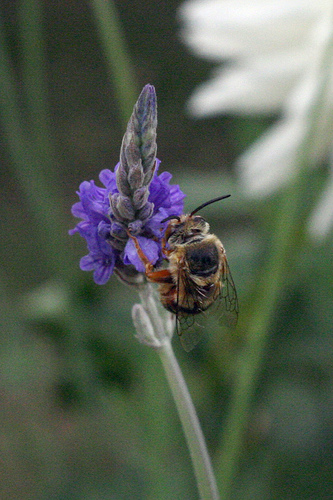

In [311]:
explain_model.set_dataloader(transform_func)
explain_model.set_image_path(example_image)                               
explain_model.transform_image()                                     
explain_model.raw_image

### 4* 
Grad-Cam functions target one of the layers inside CNNs to track gradients, AFAIK they have to be CNN layers. We need to select layer, which needs some operations on the network.

Model is in block form, block contains more than one layers. One of the layers is layer4, a block contains lots of things.

In [312]:
print(model.layer4)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

We need to flatten these nested list, refine the model architecture. In pretrained weights, these blocks are common and transfer learning is very widely used. So, we can refine the nested loops by get_children function.

In [313]:
explain_model.get_children(model)[0:10]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)]

Then we can filter CNNs by 

In [314]:
[i for i in explain_model.get_children(model) if type(i)==torch.nn.modules.conv.Conv2d ][0:10]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)]

Which is done by explain_model.get_conv_layers()

In [315]:
conv_layers = explain_model.get_conv_layers()

Choosing the last CNN layer from ordered list, that's what we have for visualisation.

Here's an evidence that model is not only a bee-ant classifier but green leaf vs. colorful flowers classifier.

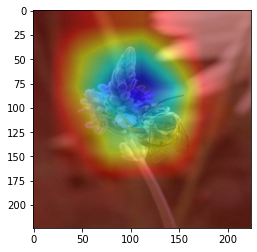

In [316]:
chosen_layer = explain_model.get_conv_layers()[-3]
explain_model.set_target_layers(explain_model.get_conv_layers()[-1])  
cam_mask = explain_model.gradcam_explainer(target_category = 1)
vis = explain_model.visualize_with_mask(cam_mask)
plt.imshow(vis)


In [317]:
original_img_list =[]
ant_explanation_list =[]
bee_explanation_list =[]


for img_ in tqdm(example_image_list):
    explain_model.set_image_path(img_)
    explain_model.transform_image()
    cam_mask_ant = explain_model.gradcam_explainer(target_category = 0)
    vis_ant = explain_model.visualize_with_mask(cam_mask_ant)
    cam_mask_bee = explain_model.gradcam_explainer(target_category = 1)
    vis_bee = explain_model.visualize_with_mask(cam_mask_bee)


    original_img_list.append(np.array(explain_model.raw_image.resize((vis_ant.shape[0],vis_ant.shape[1]))))
    ant_explanation_list.append(vis_ant) 
    bee_explanation_list.append(vis_bee) 



100%|██████████| 29/29 [00:18<00:00,  1.59it/s]


In [318]:
vis_list = []
for i in range(len(original_img_list)) :
    vis_list.append(original_img_list[i])
    vis_list.append(ant_explanation_list[i])
    vis_list.append(bee_explanation_list[i])

### Some Predictions  <a class="anchor" id="somepredictions"></a>

          Original        -     Ant     -        Bee


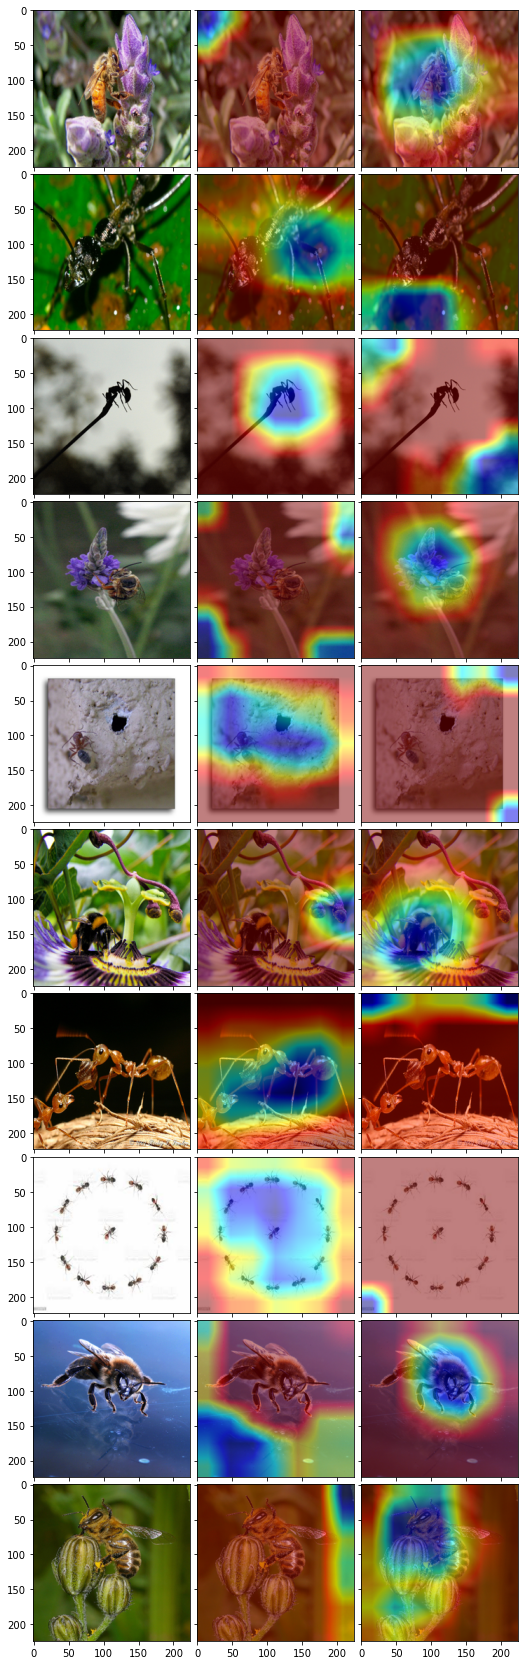

In [336]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np


fig = plt.figure(figsize=(len(vis_list[:3*10])*20., 30.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(int(len(vis_list[:3*10])/3), 3),  # creates 2x2 grid of axes
                 axes_pad=0.1)# pad between axes in inch.                 


for ax, im in zip(grid, vis_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

print("          Original        -     Ant     -        Bee") ## faster/easier than doing with matplotlib  :)
plt.show()
